In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from load_mnist import load_mnist
X_train, y_train, X_test, y_test = load_mnist()


In [6]:
def initialize_model(K, D, D_i, D_o):
    all_weights = [None] * (K+1)
    all_biases = [None] * (K+1)

    # Create input and output layer
    if K==0:
        all_weights[0] = np.random.randn(D_o, D_i) * np.sqrt(2 / D_i)
    else:
        all_weights[0] = np.random.randn(D, D_i) * np.sqrt(2 / D_i)
        all_weights[-1] = np.random.randn(D_o, D) * np.sqrt(2 / D) 
        all_biases[0] = np.zeros((D,1))
        
    all_biases[-1]= np.zeros((D_o,1))
    # Create intermediate layers
    for layer in range(1,K):
        all_weights[layer] = np.random.randn(D, D) * np.sqrt(2 / D)
        all_biases[layer] = np.zeros((D,1))
    print(all_weights)
    print(all_biases)
    return all_weights, all_biases  
    

In [7]:
def ReLU(x):
    return np.maximum(0,x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exps / np.sum(exps, axis=0, keepdims=True)

def compute_cost(net_output, y):
    return -np.mean(np.sum(y * np.log(net_output + 1e-10), axis=0))

def d_cost_d_output(net_output, y):
    return net_output - y

In [8]:
def forward_pass(net_input, all_weights, all_biases):
    K = len(all_weights) - 1  # Number of layers
    all_f = [None] * (K + 1)
    all_h = [None] * (K + 1)
    all_h[0] = net_input

    for layer in range(K + 1):
        all_f[layer] = all_biases[layer] + np.matmul(all_weights[layer], all_h[layer])
        if layer < K:
            all_h[layer + 1] = ReLU(all_f[layer])

    net_output = softmax(all_f[K])  # Output layer softmax
    return net_output, all_f, all_h

In [9]:
def indicator_function(x):
    return np.where(x > 0, 1, 0)


def backward_pass(all_weights, all_biases, all_f, all_h, y):
    K = len(all_weights) - 1  # Number of layers
    all_dl_dweights = [None] * (K + 1)
    all_dl_dbiases = [None] * (K + 1)
    all_dl_df = [None] * (K + 1)
    all_dl_dh = [None] * (K + 1)
    
    # Output first
    all_dl_df[K] = d_cost_d_output(softmax(all_f[K]), y)
    # from output to input layer
    for layer in range(K, -1, -1):
        batch_size = y.shape[1]

        all_dl_dbiases[layer] = np.sum(all_dl_df[layer], axis=1, keepdims=True) / batch_size
        all_dl_dweights[layer] = np.dot(all_dl_df[layer], all_h[layer].T) / batch_size

        if layer > 0:
            all_dl_dh[layer - 1] = np.dot(all_weights[layer].T, all_dl_df[layer]) * indicator_function(all_f[layer - 1])

        if layer > 0:
            all_dl_df[layer - 1] = all_dl_dh[layer - 1]

    return all_dl_dweights, all_dl_dbiases


In [10]:
def update_parameters(learning_rate, all_dl_dweights, all_dl_dbiases, all_weights, all_biases):
    for i in range(len(all_weights)):
        all_weights[i] -= learning_rate * all_dl_dweights[i]
        all_biases[i] -= learning_rate * all_dl_dbiases[i]


In [11]:
def predict(net_input, all_weights, all_biases):
    net_output, _, _ = forward_pass(net_input, all_weights, all_biases)
    return net_output

In [12]:
def random_mini_batches(X, Y, batch_size):
    I = X.shape[0] 
    mini_batches = []
    
    permutation = np.random.permutation(I)
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]
    
    num_batches = I // batch_size
    for k in range(num_batches):
        X_mini = shuffled_X[k * batch_size:(k + 1) * batch_size, :]
        Y_mini = shuffled_Y[k * batch_size:(k + 1) * batch_size, :]
        mini_batches.append((X_mini, Y_mini))
    
    if I % batch_size != 0:
        X_mini = shuffled_X[num_batches * batch_size:, :]
        Y_mini = shuffled_Y[num_batches * batch_size:, :]
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

provided visualization-function

In [13]:
from matplotlib import pyplot as plt
import numpy as np
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = range(1, len(train_costs)+1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Iterations', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

In [28]:
def train_model(all_weights, all_biases, learning_rate, num_epochs, batches):
    train_costs = []
    train_accuracies = []
    test_costs = []
    tests_accuracies = []

    for epoch in range(num_epochs):
        for batch in batches:
            X_mini, y_mini = batch
            X_mini = np.transpose(X_mini)
            y_mini = np.transpose(y_mini)
                
            net_output, all_f, all_h = forward_pass(X_mini, all_weights, all_biases)
            cost = compute_cost(net_output, y_mini)
            all_dl_dweights, all_dl_dbiases = backward_pass(all_weights, all_biases, all_f, all_h, y_mini)
            update_parameters(learning_rate, all_dl_dweights, all_dl_dbiases, all_weights, all_biases)

        cost = compute_cost(net_output, y_mini)     
        training_predictions = np.argmax(net_output, axis=0)
        training_labels = np.argmax(y_mini, axis=0)
        training_accuracy = np.mean(training_predictions == training_labels)
        train_accuracies.append(training_accuracy) 
        train_costs.append(cost)

        test_net_output = predict(np.transpose(X_test), all_weights, all_biases) 
        test_predictions = np.argmax(test_net_output, axis=0)  
        test_cost = compute_cost(test_net_output, np.transpose(y_test)) 

        test_costs.append(test_cost)
        tests_accuracies.append(np.mean(test_predictions == np.argmax(np.transpose(y_test), axis=0)))
  
    return train_costs, train_accuracies, test_costs, tests_accuracies, all_weights, all_biases 

Training a model!

[array([[-0.00418847, -0.02988463,  0.02338633, ...,  0.00389997,
         0.02581063,  0.00330999],
       [ 0.00269516,  0.04670201, -0.00255004, ...,  0.02802845,
         0.02237394,  0.00169907],
       [ 0.04591765,  0.00688794,  0.08501128, ...,  0.0904074 ,
        -0.04615111,  0.03163043],
       ...,
       [ 0.00176765, -0.0268764 ,  0.04674009, ...,  0.03018007,
         0.12007218, -0.05613567],
       [ 0.07562701, -0.0330076 ,  0.15669057, ..., -0.01526081,
         0.0754275 ,  0.13549634],
       [ 0.0811795 , -0.09746645,  0.03155197, ...,  0.03603119,
        -0.01790749,  0.01774012]]), array([[-0.05319105, -0.00643358,  0.17659127, ...,  0.33004648,
         0.27349458, -0.08290183],
       [-0.09232631, -0.35192402,  0.16181144, ..., -0.14985862,
         0.22058716, -0.29805554],
       [-0.10103787, -0.21830366, -0.0257995 , ..., -0.18588224,
        -0.09757116,  0.17682973],
       ...,
       [ 0.02721646,  0.05202692, -0.18154498, ...,  0.14903686,
        

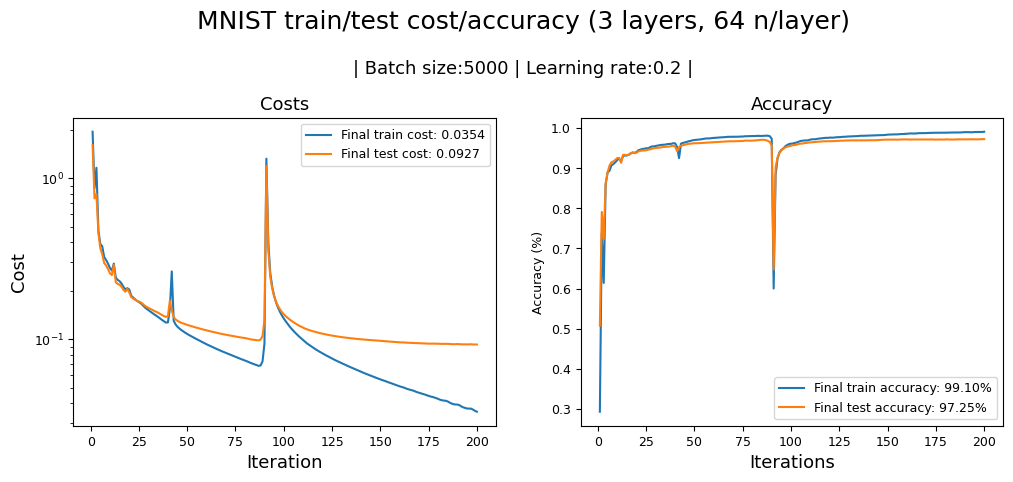

In [29]:
K = 3 # Number of hidden layers
#D = 256  # Number of neurons per hidden layer
D = 64
D_i = 784  # Input layer dimension
D_o = 10  # Output layer dimension
batch_size = 5000
learning_rate = 0.2
momentum_beta = 0.9
iterations = 200

all_weights, all_biases = initialize_model(K,D,D_i,D_o)
batches = random_mini_batches(X_train, y_train, batch_size)

train_costs, train_accuracies, test_costs, tests_accuracies, all_weights, all_biases = train_model(all_weights, all_biases, learning_rate, iterations, batches)
training_curve_plot(f'MNIST train/test cost/accuracy ({K} layers, {D} n/layer)', train_costs, test_costs, train_accuracies, tests_accuracies, batch_size, learning_rate)

Visualizing the weight-vectors

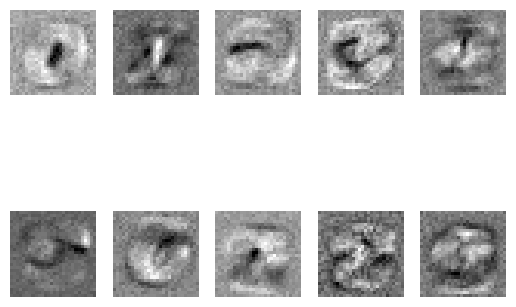

In [76]:
weights = np.array(all_weights)

f, a = plt.subplots(2,5)
a = a.ravel()
for i in range(0,10,1):
    img = np.reshape(weights[0,i,:], (28, 28))
    a[i].imshow(img,cmap='gray')
    a[i].axis('off')

**Exercise 4. Implement batch gradient descent with momentum**

**SGD** 
$$\boldsymbol\Omega_i \leftarrow \boldsymbol\Omega_{i-1}-\alpha\frac{\partial L}{\partial \boldsymbol\Omega}$$
$$\boldsymbol\beta_i \leftarrow \boldsymbol\beta_{i-1}-\alpha\frac{\partial L}{\partial \boldsymbol\beta}, \text{    at it=}i$$


**SGD with momentum**
$$\mathbf{m}_{t+1}\leftarrow\boldsymbol\beta\cdot\mathbf{m}_t+(1-\boldsymbol\beta)\sum_{i\in\mathcal{B}_t}\frac{\partial \ell_i}{\partial \boldsymbol\Omega}$$
$$\boldsymbol\Omega_{t+1}\leftarrow\boldsymbol\Omega_t-\alpha\cdot\mathbf{m}_{t+1}$$

Formally

$$m_{\Omega i}= \beta\cdot m_{\Omega i}+(1-\beta)\cdot \frac{\partial L}{\partial \Omega}$$
$$m_{\beta i}= \beta\cdot m_{\beta i}+(1-\beta)\cdot \frac{\partial L}{\partial \beta}$$

$$\boldsymbol\Omega_{i+1}=\boldsymbol\Omega_{i}-\alpha\cdot m_{\Omega i}$$
$$\boldsymbol\beta_{i+1}=\boldsymbol\beta_{i}-\alpha\cdot m_{\beta i}$$

In [21]:
def update_parameters_momentum(learning_rate, beta, all_dl_dweights, all_dl_dbiases, 
                               all_weights, all_biases, m_weights, m_biases):
    for i in range(len(all_weights)):
        m_weights[i] = beta * m_weights[i] + (1 - beta) * all_dl_dweights[i]
        m_biases[i] = beta * m_biases[i] + (1 - beta) * all_dl_dbiases[i]

        all_weights[i] -= learning_rate * m_weights[i]
        all_biases[i] -= learning_rate * m_biases[i]

    return all_weights, all_biases, m_weights, m_biases

def initialize_momentum(all_weights, all_biases):
    m_weights = [np.zeros_like(w) for w in all_weights]
    m_biases = [np.zeros_like(b) for b in all_biases]    
    return m_weights, m_biases


In [23]:
def train_model_momentum(all_weights, all_biases, learning_rate, num_epochs, batches, momentum_beta):
    train_costs = []
    train_accuracies = []
    test_costs = []
    tests_accuracies = []
    m_weights, m_biases = initialize_momentum(all_weights, all_biases)
    beta = momentum_beta

    for epoch in range(num_epochs):
        for batch in batches:
            X_mini, y_mini = batch
            X_mini = np.transpose(X_mini)
            y_mini = np.transpose(y_mini)
                
            net_output, all_f, all_h = forward_pass(X_mini, all_weights, all_biases)
            cost = compute_cost(net_output, y_mini)
            all_dl_dweights, all_dl_dbiases = backward_pass(all_weights, all_biases, all_f, all_h, y_mini)
            update_parameters_momentum(learning_rate, beta, all_dl_dweights, all_dl_dbiases, all_weights, all_biases, m_weights, m_biases)

        cost = compute_cost(net_output, y_mini)     
        training_predictions = np.argmax(net_output, axis=0)
        training_labels = np.argmax(y_mini, axis=0)
        training_accuracy = np.mean(training_predictions == training_labels)
        train_accuracies.append(training_accuracy) 
        train_costs.append(cost)

        test_net_output = predict(np.transpose(X_test), all_weights, all_biases) 
        test_predictions = np.argmax(test_net_output, axis=0)  
        test_cost = compute_cost(test_net_output, np.transpose(y_test)) 

        test_costs.append(test_cost)
        tests_accuracies.append(np.mean(test_predictions == np.argmax(np.transpose(y_test), axis=0)))
  
    return train_costs, train_accuracies, test_costs, tests_accuracies, all_weights, all_biases 

[array([[ 0.04301985,  0.03918152,  0.04829567, ..., -0.02034624,
        -0.0650581 , -0.02887647],
       [ 0.06591852,  0.01040881, -0.04619159, ...,  0.00921166,
         0.09638033,  0.02031979],
       [ 0.10817475,  0.1223163 , -0.01323596, ..., -0.04212761,
        -0.05117478, -0.0006564 ],
       ...,
       [ 0.02486553, -0.01338548, -0.03441229, ..., -0.04201442,
        -0.02119816, -0.04535173],
       [-0.00178539, -0.03443863, -0.06459973, ..., -0.06902111,
        -0.01112856,  0.08616552],
       [-0.02702847, -0.03533809,  0.02347535, ..., -0.01223239,
         0.01038618, -0.05964125]]), array([[-0.11655771, -0.01962122,  0.07189635, ...,  0.22967891,
         0.05759928, -0.03531178],
       [-0.11860995,  0.26406053, -0.22303636, ...,  0.01449602,
        -0.09160116, -0.04230659],
       [-0.02623637, -0.07158046,  0.06428828, ..., -0.17025104,
        -0.31701213,  0.37611631],
       ...,
       [-0.18322636, -0.31730613, -0.13663122, ...,  0.06041153,
        

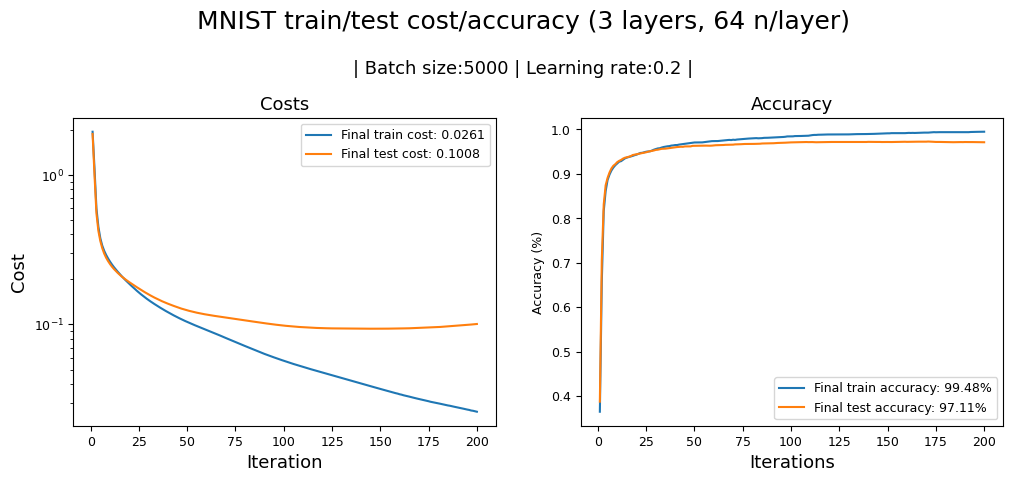

In [26]:
K = 3 # Number of hidden layers
#D = 256  # Number of neurons per hidden layer
D = 64
D_i = 784  # Input layer dimension
D_o = 10  # Output layer dimension
batch_size = 5000
learning_rate = 0.2
momentum_beta = 0.9
iterations = 200

all_weights, all_biases = initialize_model(K,D,D_i,D_o)
batches = random_mini_batches(X_train, y_train, batch_size)

train_costs, train_accuracies, test_costs, tests_accuracies, all_weights, all_biases = train_model_momentum(all_weights, all_biases, learning_rate, iterations, batches, momentum_beta)
training_curve_plot(f'MNIST train/test cost/accuracy ({K} layers, {D} n/layer)', train_costs, test_costs, train_accuracies, tests_accuracies, batch_size, learning_rate)